# Model validation

Model validation is a critical step in the development and assessment of credit risk models. It involves evaluating the performance and reliability of the model to ensure its accuracy and predictive capability. The purpose of model validation is to assess how well the model performs on unseen data and to identify any potential weaknesses or limitations.

We obtained best model parameter for xgboost from last step

**Best model parameters**: {'xgb__colsample_bytree': 0.9, 'xgb__eta': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} 

**Best model score**: 0.8674056333776022

best model parameter for random forest from last step

**Best model parameters**: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}

**Best model score**: 0.904551



And we will perform model validation in this step which includes:

**Split the data**: Divide your dataset into a training set and a validation/test set. The training set will be used to train the model, and the validation/test set will be used to evaluate its performance.

**Train the model**: Use the training set to train your credit risk model. This could involve various techniques such as logistic regression, random forest, or gradient boosting.

**Evaluate model performance**: Apply the trained model to the validation/test set and assess its performance using appropriate evaluation metrics for credit risk models. Common evaluation metrics include accuracy, precision, recall, F1-score, area under the ROC curve (AUC-ROC), and Gini coefficient.

**Assess model calibration**: Check if the predicted probabilities from your model are well-calibrated. Calibration ensures that the predicted probabilities reflect the true likelihood of default. You can use calibration plots, reliability curves, or Hosmer-Lemeshow tests to assess calibration.

**Validate predictive power**: Assess the predictive power of your model by checking if it performs well on new, unseen data. This can be done by using cross-validation techniques such as k-fold cross-validation or hold-out validation on multiple validation/test sets.

**Fine-tune and iterate**: If necessary, refine your model by adjusting hyperparameters, trying different algorithms, or including additional features. Repeat steps 2-6 to iteratively improve your model's performance.

**Document and report**: Document the validation process, including the data used, model specifications, evaluation metrics, and results. Prepare a comprehensive report summarizing the model's performance and limitations.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from tabulate import tabulate

import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier

import joblib

In [2]:
best_model_XGBOOST = joblib.load('models/best_model_XGBOOST.pkl')

In [22]:
best_model_RF = joblib.load('models/best_model_RF.pkl')

### Evaluate model performance:

In [4]:
df_train_processed = pd.read_csv("csv/processed_data_train.csv")
df_test_processed = pd.read_csv("csv/processed_data_test.csv")


df_train_oversampled = pd.read_csv("csv/oversampled_data.csv")

In [5]:
## try to create new cols on top of oversampled data
# Create a new column 'TotalPastDue' by summing the values of the three columns
df_train_oversampled['TotalPastDue'] = df_train_oversampled['NumberOfTime30-59DaysPastDueNotWorse'] + df_train_oversampled['NumberOfTimes90DaysLate'] + df_train_oversampled['NumberOfTime60-89DaysPastDueNotWorse']

# Drop the individual columns if desired
df_train_oversampled = df_train_oversampled.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], axis=1)

In [6]:
y_train_oversampled = df_train_oversampled['SeriousDlqin2yrs'].astype('uint8')
X_train_oversampled = df_train_oversampled.drop(['SeriousDlqin2yrs'], axis=1)

In [7]:
def split_data(X_train, Y_train, test_size=0.3, random_state=2020):
    """
    Split the data into training and validation sets.
    
    Parameters:
    - X_train: The features (input variables) for training.
    - Y_train: The target variable for training.
    - test_size: The proportion of the data to include in the validation set. Default is 0.3.
    - random_state: The random state for reproducibility. Default is 2020.
    
    Returns:
    - X_train: The training features.
    - val_x: The validation features.
    - Y_train: The training target variable.
    - val_y: The validation target variable.
    """
    X_train, val_x, Y_train, val_y = train_test_split(
        X_train, Y_train, test_size=test_size, random_state=random_state)
    
    return X_train, val_x, Y_train, val_y


In [8]:
def evaluate_model(model, X_train, Y_train, val_x, val_y):
    # Extract the model name from the model object
    model_name = type(model).__name__
    
    if '-' in model_name:
        model_name = model_name.split('-')[1]

    # Calculate the accuracy score on the training set
    accuracy_train = accuracy_score(Y_train, model.predict(X_train))
    print("Accuracy on training set:", accuracy_train)

    # Calculate the ROC AUC score on the training set
    roc_auc_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
    print("ROC AUC score on training set:", roc_auc_train)

    # Calculate the accuracy score on the validation set
    accuracy_val = accuracy_score(val_y, model.predict(val_x))
    print("Accuracy on validation set:", accuracy_val)

    # Calculate the ROC AUC score on the validation set
    roc_auc_val = roc_auc_score(val_y, model.predict_proba(val_x)[:, 1])
    print("ROC AUC score on validation set:", roc_auc_val)

    # Compute the false positive rate, true positive rate, and thresholds for training set
    fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])

    # Compute the false positive rate, true positive rate, and thresholds for validation set
    fpr_val, tpr_val, thresholds_val = roc_curve(val_y, model.predict_proba(val_x)[:, 1])

    # Plot the ROC curves
    plt.plot(fpr_train, tpr_train, label='Training')
    plt.plot(fpr_val, tpr_val, label='Validation')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Default')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ({})'.format(model_name))
    plt.legend()
    plt.show()


In [9]:
def display_evaluation_metrics(model, val_x, val_y):
    """
    Calculates and displays the evaluation metrics for a classification model.

    Parameters:
    - model: Trained classification model
    - val_x: Validation set features
    - val_y: Validation set target variable

    Prints a table showing the evaluation metrics: Accuracy, Precision, Recall, F1-score, AUC-ROC, and Gini coefficient.
    """
    
    # Make predictions on the validation set
    y_pred = model.predict(val_x)

    # Calculate accuracy
    accuracy = accuracy_score(val_y, y_pred)

    # Calculate precision
    precision = precision_score(val_y, y_pred)

    # Calculate recall
    recall = recall_score(val_y, y_pred)

    # Calculate F1-score
    f1 = f1_score(val_y, y_pred)

    # Calculate predicted probabilities for positive class
    y_pred_prob = model.predict_proba(val_x)[:, 1]

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(val_y, y_pred_prob)

    # Calculate Gini coefficient
    gini = 2 * auc_roc - 1

    # Create a list of metric names and values
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC', 'Gini coefficient']
    metric_values = [accuracy, precision, recall, f1, auc_roc, gini]

    # Create a list of metric rows
    metric_rows = [[name, value] for name, value in zip(metric_names, metric_values)]

    # Print the table for evaluation metrics
    print(tabulate(metric_rows, headers=['Metric', 'Value'], tablefmt='orgtbl'))

In [10]:
###
###X_train, val_x, Y_train, val_y = split_data(df_train_processed.drop('SeriousDlqin2yrs', axis=1), df_train_processed['SeriousDlqin2yrs'])

In [11]:
## split oversampled data
X_train, val_x, Y_train, val_y = split_data(df_train_oversampled.drop('SeriousDlqin2yrs', axis=1), df_train_oversampled['SeriousDlqin2yrs'])

In [12]:
df_train_oversampled


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,SeriousDlqin2yrs,TotalPastDue
0,0.766127,45,0.802982,9120.000000,13,6,2.000000,1,2
1,0.957151,40,0.121876,2600.000000,4,0,1.000000,0,0
2,0.658180,38,0.085113,3042.000000,2,0,0.000000,0,2
3,0.233810,30,0.036050,3300.000000,5,0,0.000000,0,0
4,0.907239,49,0.024926,63588.000000,7,1,0.000000,0,1
...,...,...,...,...,...,...,...,...,...
272499,0.550475,40,0.292152,5700.000000,6,0,1.777566,1,1
272500,0.269107,26,0.174355,3500.000000,4,0,0.000000,1,1
272501,0.496744,80,33.894479,5400.000000,2,0,0.000000,1,0
272502,0.900824,52,0.861294,3330.939939,14,1,1.373374,1,2


Accuracy on training set: 0.9500503271263211
ROC AUC score on training set: 0.9908165452619984
Accuracy on validation set: 0.904136901849496
ROC AUC score on validation set: 0.9692023207500553


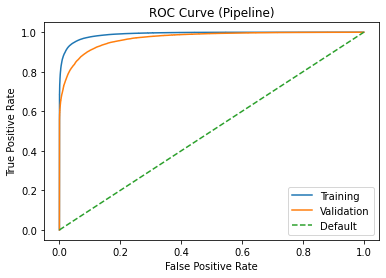

In [13]:
evaluate_model(best_model_XGBOOST, X_train, Y_train, val_x, val_y)


In [14]:
display_evaluation_metrics(best_model_XGBOOST, val_x, val_y)


| Metric           |    Value |
|------------------+----------|
| Accuracy         | 0.904137 |
| Precision        | 0.913122 |
| Recall           | 0.893558 |
| F1-score         | 0.903234 |
| AUC-ROC          | 0.969202 |
| Gini coefficient | 0.938405 |


In [15]:
# Make predictions on the validation set
y_pred = best_model_XGBOOST.predict(val_x)

# Calculate accuracy
accuracy = accuracy_score(val_y, y_pred)

# Calculate precision
precision = precision_score(val_y, y_pred)

# Calculate recall
recall = recall_score(val_y, y_pred)

# Calculate F1-score
f1 = f1_score(val_y, y_pred)

# Calculate predicted probabilities for positive class
y_pred_prob = best_model_XGBOOST.predict_proba(val_x)[:, 1]

# Calculate AUC-ROC
auc_roc = roc_auc_score(val_y, y_pred_prob)

# Calculate Gini coefficient
gini = 2 * auc_roc - 1

# Print the evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc_roc))
print("Gini coefficient: {:.4f}".format(gini))


Accuracy: 0.9041
Precision: 0.9131
Recall: 0.8936
F1-score: 0.9032
AUC-ROC: 0.9692
Gini coefficient: 0.9384


**Accuracy**: Accuracy represents the overall correctness of the model's predictions. In the context of a credit risk loan default model, it indicates the proportion of correctly predicted outcomes (both defaults and non-defaults) out of the total predictions. An accuracy of 0.849716 means that the model predicted the correct outcome for approximately 84.97% of the cases.

**Precision**: Precision measures the ability of the model to correctly identify loan defaults among the predicted default cases. In other words, it quantifies the proportion of correctly predicted defaults out of all the cases predicted as defaults. A precision of 0.779423 suggests that around 77.94% of the predicted defaults were actually true defaults.

**Recall**: Recall, also known as sensitivity or true positive rate, indicates the ability of the model to identify true defaults among all the actual default cases. It measures the proportion of correctly identified defaults out of all the actual defaults. A recall of 0.976083 indicates that the model identified approximately 97.61% of the actual defaults.

**F1-score**: The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance by considering both precision and recall. A higher F1-score (in this case, 0.866738) indicates a better balance between precision and recall.

**AUC-ROC**: The Area Under the Receiver Operating Characteristic Curve (AUC-ROC) measures the model's ability to discriminate between default and non-default cases across different classification thresholds. A higher AUC-ROC value (in this case, 0.969846) indicates a better ability to distinguish between defaults and non-defaults.

**Gini coefficient**: The Gini coefficient is a derived metric from the AUC-ROC. It quantifies the model's discrimination power by calculating the difference between the AUC-ROC value and the random classification line (0.5 for binary classification). A higher Gini coefficient (in this case, 0.939692) indicates a better discrimination ability of the model.

### Lift Curve

<ipython-input-16-3aaeaef937ae>:15: RuntimeWarning: divide by zero encountered in divide
  lift = cumulative_percentage / random_percentage


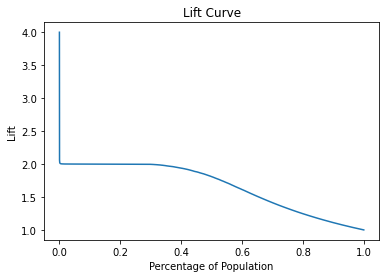

In [16]:
# for best XGBOOST model 
# Sort the predicted probabilities in descending order
sorted_indices = np.argsort(y_pred_prob)[::-1]
sorted_y_pred_prob = y_pred_prob[sorted_indices]
sorted_val_y = np.array(val_y)[sorted_indices]

# Calculate the cumulative number of positive samples and cumulative percentage
cumulative_positives = np.cumsum(sorted_val_y)
cumulative_percentage = cumulative_positives / np.sum(sorted_val_y)

# Calculate the expected random percentage
random_percentage = np.linspace(0, 1, len(val_y))

# Calculate the lift
lift = cumulative_percentage / random_percentage

# Plot the Lift curve
plt.plot(random_percentage, lift)
plt.xlabel("Percentage of Population")
plt.ylabel("Lift")
plt.title("Lift Curve")
plt.show()



### Assess model calibration

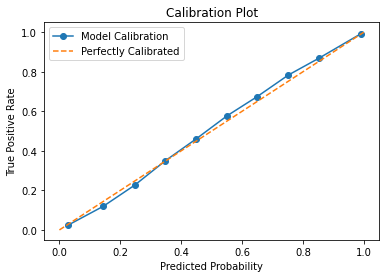

In [17]:
from sklearn.calibration import calibration_curve

## For xgboost model
# Compute true positive rate and predicted probabilities for the positive class
true_pos_rate, pred_probs = calibration_curve(val_y, y_pred_prob, n_bins=10)

# Create calibration plot
plt.plot(pred_probs, true_pos_rate, marker='o', linestyle='-', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Positive Rate')
plt.title('Calibration Plot')
plt.legend()
plt.show()

In [24]:
## For random forest model
display_evaluation_metrics(best_model_RF, val_x, val_y)


| Metric           |    Value |
|------------------+----------|
| Accuracy         | 0.906021 |
| Precision        | 0.904285 |
| Recall           | 0.90846  |
| F1-score         | 0.906368 |
| AUC-ROC          | 0.96996  |
| Gini coefficient | 0.93992  |


### Lift Curve

<ipython-input-19-7de6d19ce176>:15: RuntimeWarning: divide by zero encountered in divide
  lift = cumulative_percentage / random_percentage


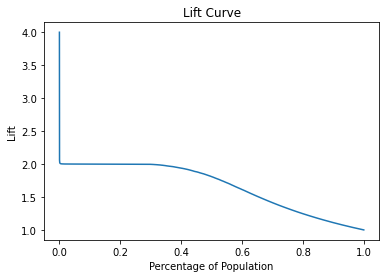

In [19]:
# for best random forest model 
# Sort the predicted probabilities in descending order
sorted_indices = np.argsort(y_pred_prob)[::-1]
sorted_y_pred_prob = y_pred_prob[sorted_indices]
sorted_val_y = np.array(val_y)[sorted_indices]

# Calculate the cumulative number of positive samples and cumulative percentage
cumulative_positives = np.cumsum(sorted_val_y)
cumulative_percentage = cumulative_positives / np.sum(sorted_val_y)

# Calculate the expected random percentage
random_percentage = np.linspace(0, 1, len(val_y))

# Calculate the lift
lift = cumulative_percentage / random_percentage

# Plot the Lift curve
plt.plot(random_percentage, lift)
plt.xlabel("Percentage of Population")
plt.ylabel("Lift")
plt.title("Lift Curve")
plt.show()


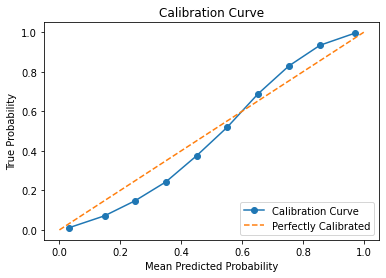

In [23]:
# For best Random Forest Model

# Make predictions on the validation set
y_pred_prob = best_model_RF.predict_proba(val_x)[:, 1]

# Calculate true probabilities and mean predicted probabilities
true_prob, pred_prob = calibration_curve(val_y, y_pred_prob, n_bins=10)

# Plot calibration curve
plt.plot(pred_prob, true_prob, marker='o', linestyle='-', label='Calibration Curve')

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

# Set plot labels and title
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In the calibration plot, the closer the points are to the diagonal reference line (perfect calibration), the better the model's calibration. If the points consistently deviate from the diagonal line, it indicates a lack of calibration.

### Validate predictive power

In [21]:
## XGboost Model
##k-fold cross-validation 
    
# Perform cross-validation using 5 folds
num_folds = 5
scores = cross_val_score(best_model_XGBOOST, X_train_oversampled, y_train_oversampled, cv=num_folds, scoring='accuracy')

# Print the cross-validation scores for each fold
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")

# Calculate and print the mean and standard deviation of the cross-validation scores
mean_score = np.mean(scores)
std_score = np.std(scores)
print(f"Mean Accuracy for XGBoost on oversampling data: {mean_score}")
print(f"Standard Deviation for XGBoost on oversampling data: {std_score}")


Fold 1: 0.8418744610190638
Fold 2: 0.9223867451973359
Fold 3: 0.9232491146951433
Fold 4: 0.924221573916075
Fold 5: 0.9245871559633028
Mean Accuracy for XGBoost on oversampling data: 0.9072638101581841
Standard Deviation for XGBoost on oversampling data: 0.0327037128403723


In [ ]:
## Random Forest Model
##k-fold cross-validation 
    
# Perform cross-validation using 5 folds
num_folds = 5
scores = cross_val_score(best_model_RF, X_train_oversampled, y_train_oversampled, cv=num_folds, scoring='accuracy')

# Print the cross-validation scores for each fold
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")

# Calculate and print the mean and standard deviation of the cross-validation scores
mean_score = np.mean(scores)
std_score = np.std(scores)
print(f"Mean Accuracy for XGBoost on oversampling data: {mean_score}")
print(f"Standard Deviation for XGBoost on oversampling data: {std_score}")

### Limitation to use XGBClassifier for a PD model:

While XGBoost (XGBClassifier) is a powerful machine learning algorithm and can be used for various tasks, including credit risk modeling and probability of default (PD) modeling, it does have certain limitations. Some of the limitations to consider when using XGBoost for a PD model are:

**Interpretability**: XGBoost is an ensemble model that combines multiple decision trees, which can make it challenging to interpret the model's predictions and understand the underlying factors contributing to the PD. This can be a limitation when transparency and explainability are important in credit risk modeling.

**Imbalanced Data**: XGBoost may face challenges when dealing with imbalanced datasets where the number of defaults is significantly lower than the number of non-defaults. In such cases, the model may prioritize accuracy on the majority class and struggle to capture the minority class adequately. Special techniques, such as class weighting or sampling strategies, may be required to address this limitation.

**Feature Engineering**: XGBoost typically relies on manually engineered features to capture the underlying patterns in the data. This means that the effectiveness of the model may be limited by the quality and relevance of the features used. It is important to carefully select and engineer relevant features for the PD model to ensure optimal performance.

**Computational Requirements**: XGBoost is a computationally intensive algorithm, particularly when dealing with large datasets or complex models. Training an XGBoost model can require substantial computational resources and time. Therefore, it is important to consider the available computing infrastructure and resources when using XGBoost for a PD model.

**Hyperparameter Tuning**: XGBoost has several hyperparameters that need to be tuned to achieve optimal performance. Finding the right combination of hyperparameters can be time-consuming and requires careful experimentation. It is important to perform thorough hyperparameter tuning to achieve the best results with XGBoost.

Despite these limitations, XGBoost remains a popular choice for PD modeling due to its ability to handle complex patterns and deliver high predictive accuracy. However, it is crucial to consider these limitations and explore alternative modeling approaches if they pose significant challenges for your specific PD modeling requirements.

### Limitation to use Random Forest for a PD model:

While Random Forest is a widely used and effective machine learning algorithm, it also has certain limitations when it comes to using it for a PD (Probability of Default) model. Some limitations of using a Random Forest model for a PD model include:

**interpretability**: Random Forest models can be considered black box models, as they do not provide clear insights into the underlying relationships between input features and the predicted probabilities. This lack of interpretability can make it challenging to explain the factors contributing to default predictions.

**Overfitting potential**: Random Forest models have a tendency to overfit the training data, especially when the number of trees (n_estimators) and the maximum depth (max_depth) are not properly tuned. Overfitting can lead to poor generalization and inaccurate predictions on new, unseen data.

**Sensitivity to input features**: Random Forest models may be sensitive to the selection and scaling of input features. If the input features are not appropriately chosen or preprocessed, it can result in biased or unreliable predictions.

**Imbalanced class distribution**: If the data used to train the Random Forest model has an imbalanced class distribution (e.g., a significantly higher number of non-default cases compared to default cases), the model may exhibit a bias towards the majority class and struggle to accurately predict the minority class (defaults).

**Computationally expensive**: Random Forest models can be computationally expensive, especially when dealing with large datasets or a large number of input features. Training and evaluating the model may require substantial computational resources and time.

**Missing data**: Random Forest models can't handle missing data in the input features. This can be a significant problem in real-world applications where missing data is common.

**Model deployment**: Random Forest models can be complex, especially if the number of trees and features is large. This can make it difficult to deploy the model in a production environment.

It's important to carefully consider these limitations and assess whether a Random Forest model is suitable for your specific PD modeling needs. It may be beneficial to explore other modeling techniques or combine Random Forest with other algorithms to overcome these limitations and enhance the predictive performance of the PD model.